In [167]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN, Dropout, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
import plotly.express as px
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

Chargement et exploration des données

In [58]:
# Chargement du dataset
df = pd.read_csv("spam.csv", encoding="iso-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [59]:
df.shape

(5572, 5)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [61]:
df.describe(include="all")

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [62]:
100 * df.isnull().sum() / df.shape[0]

,0
v1,0.000000
v2,0.000000
Unnamed: 2,99.102656
Unnamed: 3,99.784637
Unnamed: 4,99.892319


<Axes: >

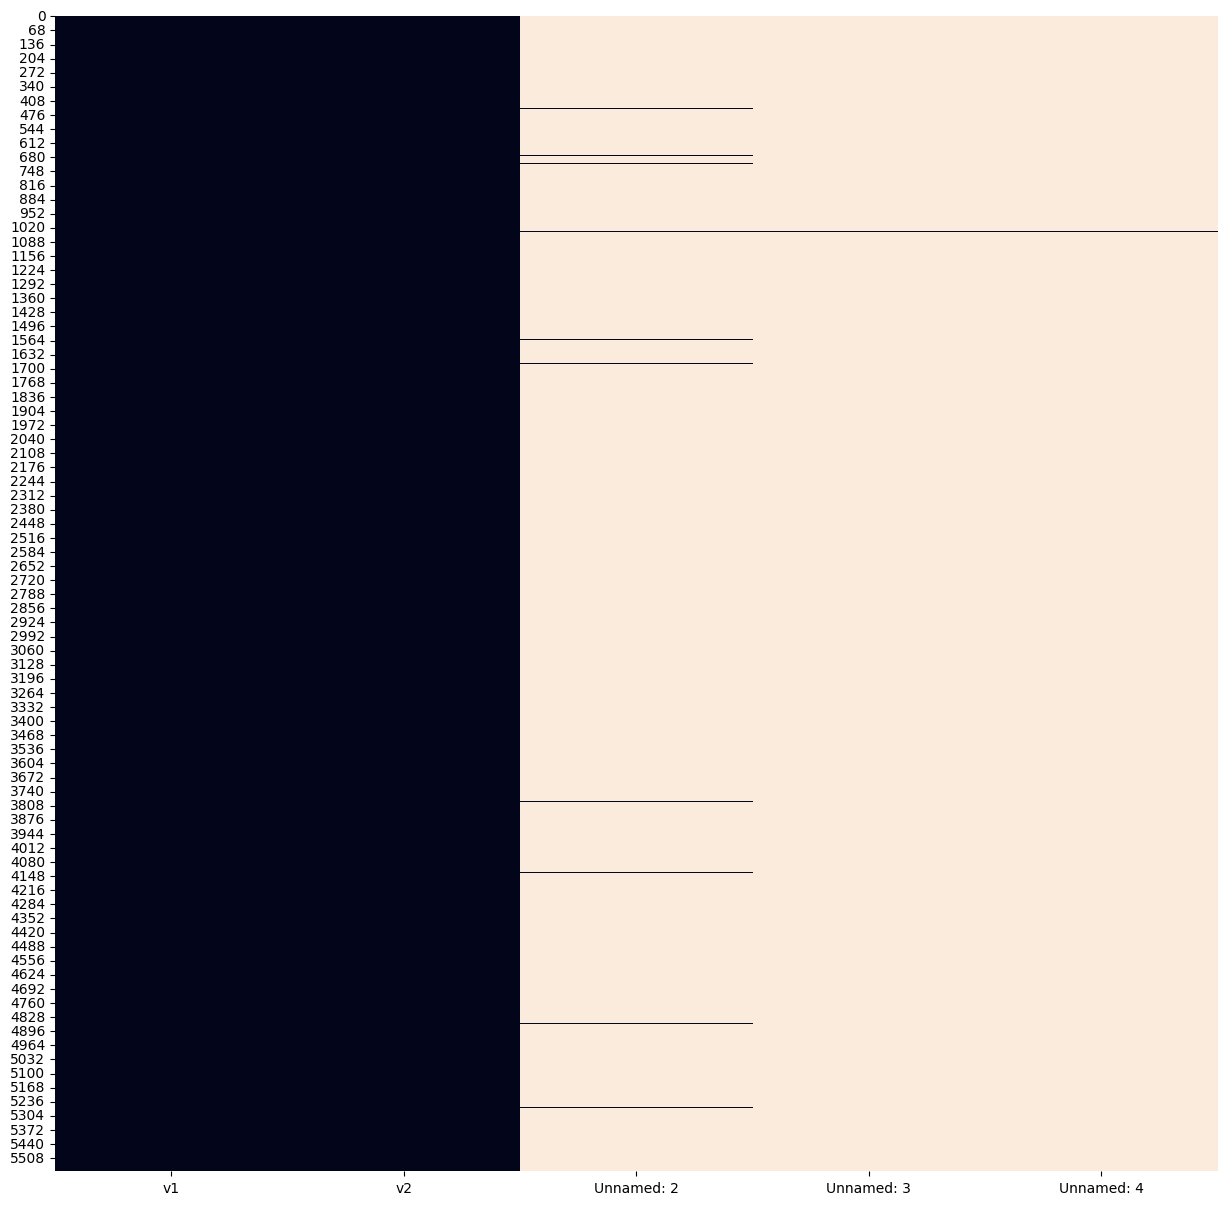

In [63]:
# Visualisation des données manquantes avec une heatmap
plt.figure(figsize=(15,15))
sns.heatmap(df.isna(), cbar=False)

In [64]:
# Répartition des spams
spam_distribution = df.groupby('v1').size().reset_index(name='count')

# Calculer le total des messages
total_messages = spam_distribution['count'].sum()

# Calculer le pourcentage de chaque type de message
spam_distribution['percentage'] = (spam_distribution['count'] / total_messages) * 100

fig = px.bar(spam_distribution,
            x='v1',
            y='percentage',
            title='Répartition des Spam et Ham',
            labels={'v1': 'Type de message', 'percentage': 'Pourcentage'},
            width=1024,
            height= 680,
            color='percentage',
            color_continuous_scale=px.colors.sequential.Viridis,
            text='percentage'
)

# Mettre en forme les annotations
fig.update_traces(texttemplate='%{text:.2f}%')

fig.show()

In [72]:
data = pd.DataFrame()
data['v1'] =  df['v1'].apply(lambda x: 1 if x == 'spam' else 0)
data['sms'] = df.iloc[:, 1:].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)
display(data)

,v1,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


Pré-traitement

In [74]:
# Longueur des sms
data['len_sms'] = data['sms'].apply(lambda x: len(x.split()))
data.head()

,v1,sms,len_sms
0,0,"Go until jurong point, crazy.. Available only ...",20
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,0,U dun say so early hor... U c already then say...,11
4,0,"Nah I don't think he goes to usf, he lives aro...",13


In [75]:
fig = px.box(data,
             y='len_sms',
             color='v1',
             title="Distribution de la longueur des SMS ('ham' vs 'spam')",
             labels={'v1': 'Type de message', 'len_sms': 'Longueur du SMS'},
             width=800,
             height=500)
fig.show()

In [76]:
# Suppression des sms dont la longueur est supérieure à 37
data = data[data["len_sms"]<=37]

In [78]:
data.shape

(5439, 3)

In [81]:
# Nettoyage
data.loc[:,'clean_sms'] = data['sms'].str.lower()\
                          .str.replace(r'[^a-zA-Z\s]', ' ', regex=True)\
                          .str.replace(r'\s+', ' ', regex=True)\
                          .str.strip()

# Longueur du SMS original et du SMS nettoyé
data.loc[:,'len_sms_original'] = data['sms'].str.len()
data.loc[:,'len_clean_sms'] = data['clean_sms'].str.len()

data = data[['v1', 'sms', 'len_sms_original', 'clean_sms', 'len_clean_sms']]


data.head()

/tmp/ipython-input-4246646376.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-4246646376.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,v1,sms,len_sms_original,clean_sms,len_clean_sms
0,0,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...,102
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in a wkly comp to win fa cup final ...,126
3,0,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say,43
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah i don t think he goes to usf he lives arou...,60


In [83]:
# Chargement du modèle Spacy de langue anglaise
nlp = spacy.load("en_core_web_sm")

# Lemmatisation et suppression des stop words
def lemmatize_text(text):
    doc = nlp(text)
    clean_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return clean_text

# Lemmatisation de la colonne 'clean_sms'
data['lemmatized_sms'] = data['clean_sms'].apply(lemmatize_text)

data.head()

,v1,sms,len_sms_original,clean_sms,len_clean_sms,lemmatized_sms
0,0,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...,102,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in a wkly comp to win fa cup final ...,126,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say,43,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah i don t think he goes to usf he lives arou...,60,nah don t think go usf live


In [84]:
# Nombre de chaînes vides dans la colonne 'lemmatized_sms'
print((data['lemmatized_sms'] == '').sum())

16


In [86]:
# Suppression des lignes de chaines vides
data = data[data['lemmatized_sms'] != '']

In [87]:
data.shape

(5423, 6)

In [89]:
data = data[['v1', 'lemmatized_sms']]

In [90]:
data.head()

,v1,lemmatized_sms
0,0,jurong point crazy available bugis n great wor...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun early hor u c
4,0,nah don t think go usf live


In [92]:
X = data["lemmatized_sms"].values
y = data["v1"].values

In [93]:
# Séparation des données en ensemble d'entraînement, de test et de validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [94]:
# Paramètres du Tokenizer
num_words = 1000  # Nombre de mots les plus fréquents à prendre en compte
max_len = max([len(seq) for seq in X]) # Longueur maximale des séquences

# initialisation du Tokeniser
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token="<OOV>")

# entrainement du Tokenizer sur l'ensemble de train
tokenizer.fit_on_texts(X_train)

In [95]:
tokenizer.index_word

{1: '<OOV>',
 2: 'u',
 3: 's',
 4: 'm',
 5: 't',
 6: 'ur',
 7: 'come',
 8: 'not',
 9: 'go',
 10: 'ok',
 11: 'get',
 12: 'free',
 13: 'good',
 14: 'send',
 15: 'll',
 16: 'know',
 17: 'day',
 18: 'lt',
 19: 'gt',
 20: 'like',
 21: 'want',
 22: 'time',
 23: 'text',
 24: 'love',
 25: 'p',
 26: 'win',
 27: 'txt',
 28: 'tell',
 29: 'think',
 30: 'need',
 31: 'today',
 32: 'stop',
 33: 'home',
 34: 'r',
 35: 'mobile',
 36: 'k',
 37: 'lor',
 38: 'da',
 39: 'reply',
 40: 'sorry',
 41: 'don',
 42: 'n',
 43: 'hi',
 44: 'new',
 45: 'work',
 46: 'week',
 47: 'later',
 48: 'phone',
 49: 'dear',
 50: 'miss',
 51: 'pls',
 52: 'd',
 53: 'c',
 54: 'ask',
 55: 'night',
 56: 'meet',
 57: 'say',
 58: 'claim',
 59: 'leave',
 60: 'message',
 61: 'oh',
 62: 'msg',
 63: 'hey',
 64: 'wait',
 65: 'wat',
 66: 'min',
 67: 'thing',
 68: 'prize',
 69: 'hope',
 70: 'number',
 71: 'b',
 72: 'try',
 73: 've',
 74: 'friend',
 75: 'great',
 76: 'yes',
 77: 'thank',
 78: 'e',
 79: 'yeah',
 80: 'www',
 81: 'late',
 82: 'c

In [105]:
# Créer le DataFrame du vocabulaire à partir du tokenizer
vocabulary_df = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word', 'index'])
vocabulary_df = vocabulary_df.sort_values(by=['index'], ascending=True)
display(vocabulary_df)

# Compter les occurrences réelles dans le corpus
word_counts = tokenizer.word_counts  # Dict {word: count}
vocabulary_df['count'] = vocabulary_df['word'].map(word_counts)
vocabulary_df = vocabulary_df.sort_values(by=['count'], ascending=False)
display(vocabulary_df)


,word,index
0,<OOV>,1
1,u,2
2,s,3
3,m,4
4,t,5
...,...,...
5420,warner,5421
5421,firmware,5422
5422,watchin,5423
5423,woah,5424


,word,index,count
1,u,2,900.0
2,s,3,519.0
3,m,4,413.0
4,t,5,356.0
5,ur,6,313.0
...,...,...,...
5417,disclose,5418,1.0
5392,clubmoby,5393,1.0
5393,immed,5394,1.0
5377,tis,5378,1.0


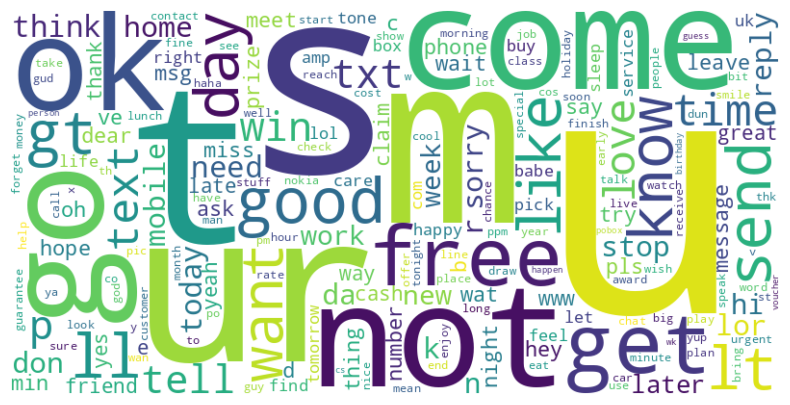

In [103]:
# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [109]:
# Séparation des Features et Labels
X = data["lemmatized_sms"].values
y = data["v1"].values

In [110]:
# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [112]:
# Paramètres du Tokenizer
num_words = 1000  # Nombre de mots les plus fréquents à prendre en compte
max_len = max([len(seq) for seq in X]) # Longueur maximale des séquences

# initialisation du Tokeniser
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token="<OOV>")

# entrainement du Tokenizer sur l'ensemble de train
tokenizer.fit_on_texts(X_train)

In [106]:
# Transformation des textes en séquences numériques
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Remplissage des séquences pour avoir la même longueur
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [111]:
X_train_padded.shape

(4338, 193)

In [ ]:
Baseline

In [115]:
# Modèle
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words+1, output_dim=32),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train_padded, y_train,
                    epochs=50,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8023 - loss: 0.4570 - val_accuracy: 0.8627 - val_loss: 0.3903
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8566 - loss: 0.4010 - val_accuracy: 0.8627 - val_loss: 0.3883
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8589 - loss: 0.3944 - val_accuracy: 0.8627 - val_loss: 0.3869
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8613 - loss: 0.3877 - val_accuracy: 0.8627 - val_loss: 0.3836
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8684 - loss: 0.3724 - val_accuracy: 0.8627 - val_loss: 0.3798
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8581 - loss: 0.3862 - val_accuracy: 0.8627 - val_loss: 0.3761
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8730 - loss: 0.3548 - val_accuracy: 0.8627 - val_loss: 0.3607
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8625 - loss: 0.3564 - val_accuracy: 0.

In [116]:
# Architecture du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 193, 32)        │        32,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,733 (381.77 KB)

 Trainable params: 32,577 (127.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,156 (254.52 KB)

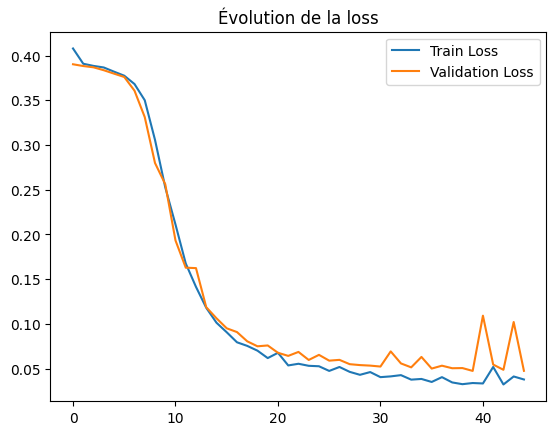

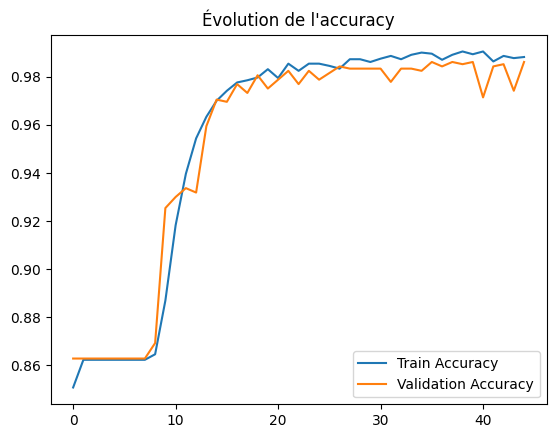

In [117]:
# Visualisation de la perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Évolution de la loss')
plt.show()

# Visualisation de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Évolution de l\'accuracy')
plt.show()

In [118]:
# Évaluation du modèle
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9861751152073732
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       936
           1       0.99      0.91      0.95       149

    accuracy                           0.99      1085
   macro avg       0.99      0.96      0.97      1085
weighted avg       0.99      0.99      0.99      1085



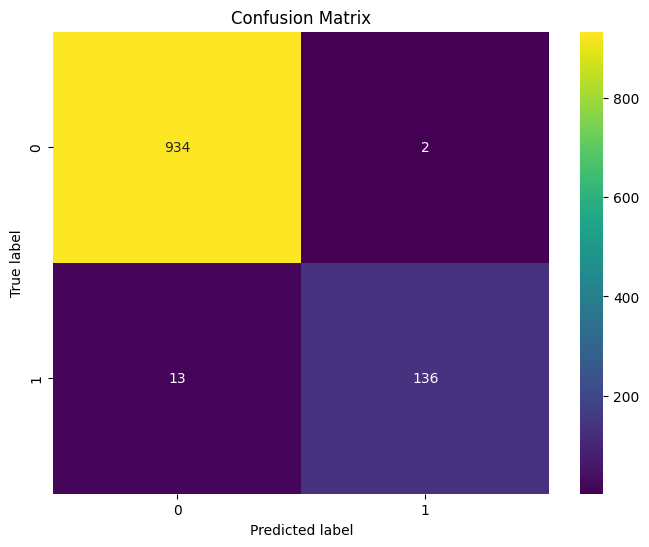

In [133]:
# Matrix de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


RNN

In [134]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words + 1, output_dim=32),
    #tf.keras.layers.Bidirectional(tf.keras.layers.RNN(32)),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train_padded, y_train,
                    epochs=50,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.8575 - loss: 0.3371 - val_accuracy: 0.9779 - val_loss: 0.0789
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9795 - loss: 0.0698 - val_accuracy: 0.9843 - val_loss: 0.0596
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9889 - loss: 0.0408 - val_accuracy: 0.9806 - val_loss: 0.0627
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9931 - loss: 0.0252 - val_accuracy: 0.9797 - val_loss: 0.0711
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9929 - loss: 0.0249 - val_accuracy: 0.9779 - val_loss: 0.0675
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9953 - loss: 0.0133 - val_accuracy: 0.9806 - val_loss: 0.0609
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9934 - loss: 0.0188 - val_accuracy: 0.9779 - val_loss: 0.0697
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [135]:
# Architecture du modèle
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 193, 32)        │        32,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,917 (448.90 KB)

 Trainable params: 38,305 (149.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,612 (299.27 KB)

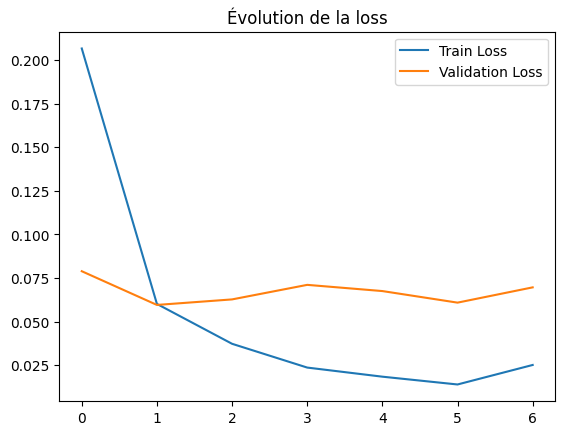

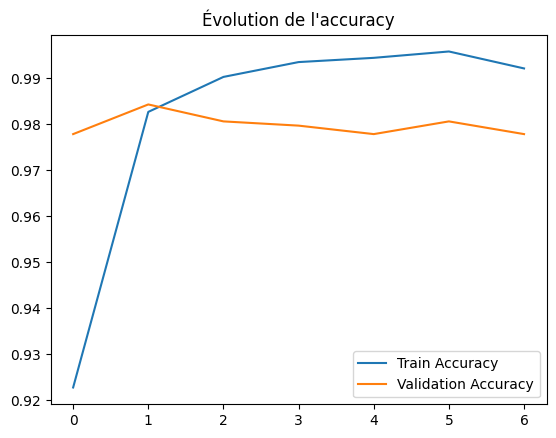

In [136]:
# Visualisation de la perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Évolution de la loss')
plt.show()

# Visualisation de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Évolution de l\'accuracy')
plt.show()

In [140]:
# Évaluation du modèle
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print("Accuracy :", accuracy_score(y_test, y_pred))
print()
print('Classification report : ')
print(classification_report(y_test, y_pred))
print()

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy : 0.9843317972350231

Classification report : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.96      0.92      0.94       149

    accuracy                           0.98      1085
   macro avg       0.98      0.96      0.97      1085
weighted avg       0.98      0.98      0.98      1085




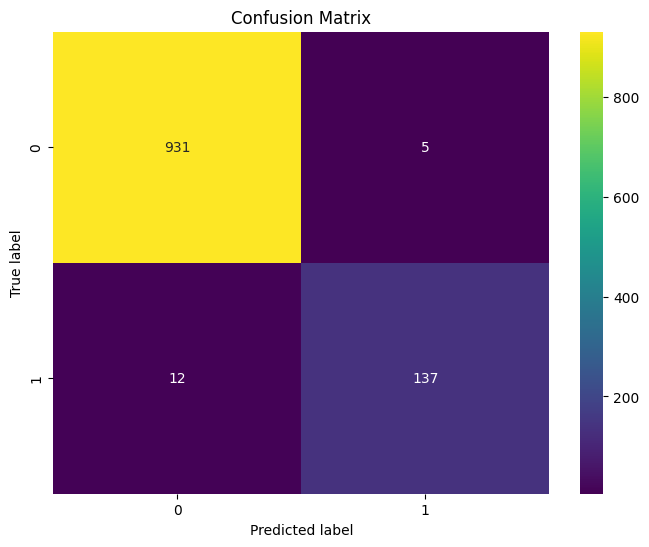

In [139]:
# Matrix de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
LSTM

In [141]:
# Modèle
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words + 1, output_dim=32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train_padded, y_train,
                    epochs=50,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 173ms/step - accuracy: 0.8657 - loss: 0.3903 - val_accuracy: 0.9677 - val_loss: 0.1036
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.9841 - loss: 0.0686 - val_accuracy: 0.9862 - val_loss: 0.0527
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.9886 - loss: 0.0425 - val_accuracy: 0.9834 - val_loss: 0.0540
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 36s 130ms/step - accuracy: 0.9921 - loss: 0.0295 - val_accuracy: 0.9770 - val_loss: 0.0684
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9921 - loss: 0.0369 - val_accuracy: 0.9843 - val_loss: 0.0511
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9955 - loss: 0.0165 - val_accuracy: 0.9843 - val_loss: 0.0548
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9979 - loss: 0.0098 - val_accuracy: 0.9843 - val_loss: 0.0573
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.9953 - loss: 0

In [142]:
# Architecture du modèle
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 193, 32)        │        32,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,357 (595.15 KB)

 Trainable params: 50,785 (198.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,572 (396.77 KB)

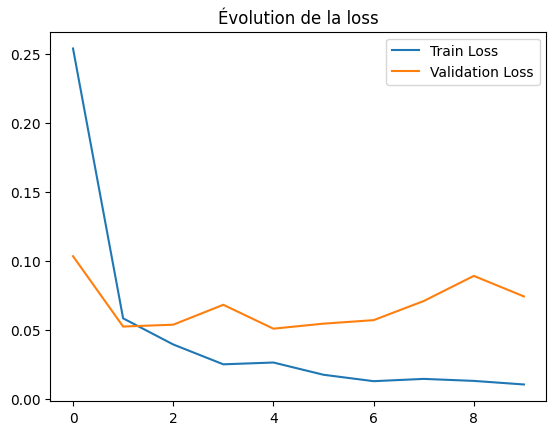

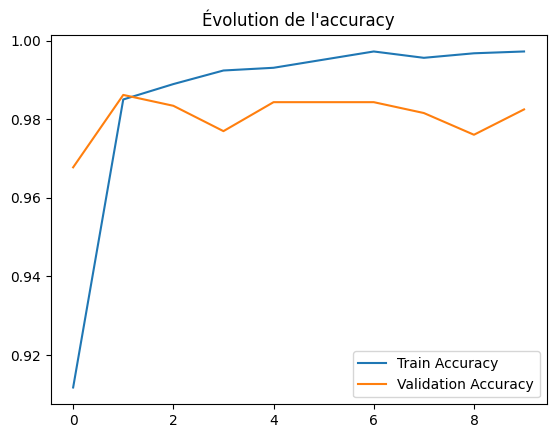

In [143]:
# Visualisation de la perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Évolution de la loss')
plt.show()

# Visualisation de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Évolution de l\'accuracy')
plt.show()

In [146]:
# Évaluation du modèle
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print("Accuracy :", accuracy_score(y_test, y_pred))
print()
print('Classification report : ')
print(classification_report(y_test, y_pred))
print()

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Accuracy : 0.9843317972350231

Classification report : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.96      0.93      0.94       149

    accuracy                           0.98      1085
   macro avg       0.97      0.96      0.97      1085
weighted avg       0.98      0.98      0.98      1085




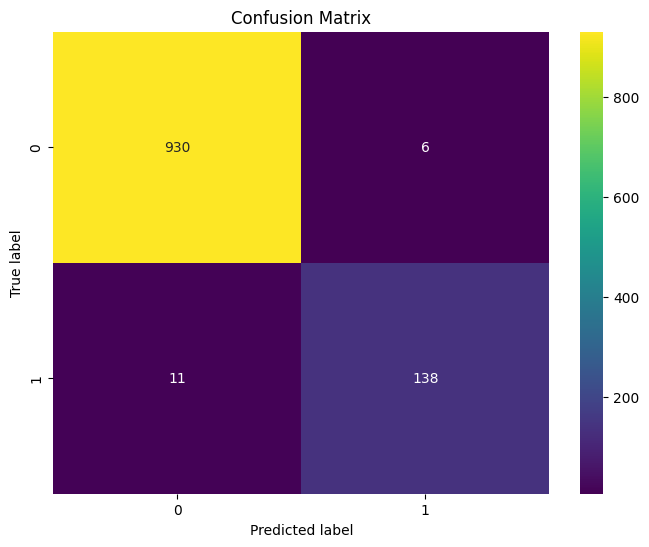

In [145]:
# Matrix de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


CNN

In [169]:
# Préparation des données
X = df['v2']
y = (df['v1'] == 'spam').astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenizer Keras
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Transformation en séquences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Paramètres
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128


In [170]:
# Modèle CNN
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilation
model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Résumé
model_cnn.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement
history_cnn = model_cnn.fit(
    X_train_padded,
    y_train,
    validation_data=(X_test_padded, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

# Prédictions
y_pred = (model_cnn.predict(X_test_padded) > 0.5).astype("int32")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8654 - loss: 0.3846 - val_accuracy: 0.9848 - val_loss: 0.0586
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9896 - loss: 0.0467 - val_accuracy: 0.9901 - val_loss: 0.0483
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9984 - loss: 0.0135 - val_accuracy: 0.9919 - val_loss: 0.0528
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9992 - loss: 0.0087 - val_accuracy: 0.9919 - val_loss: 0.0560
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 0.9910 - val_loss: 0.0680
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [171]:
# Métriques
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9901345291479821
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



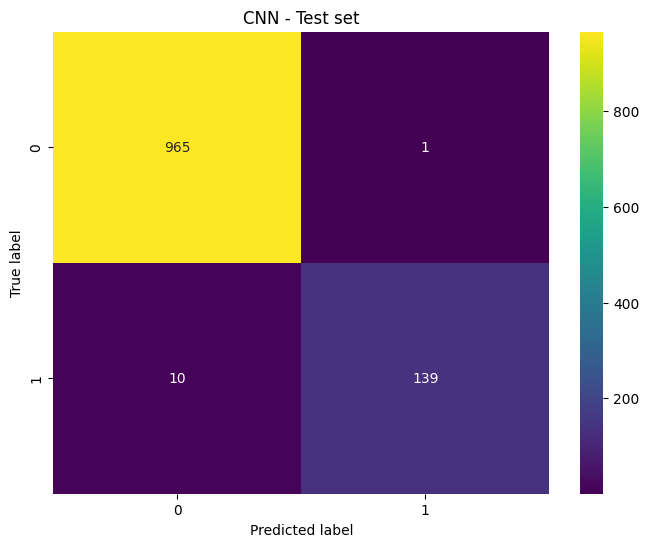

In [172]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CNN - Test set')
plt.show()